In [137]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mf-accelerator/sample_subm.csv
/kaggle/input/mf-accelerator/contest_train.csv
/kaggle/input/mf-accelerator/contest_test.csv


In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [139]:
train = pd.read_csv('/kaggle/input/mf-accelerator/contest_train.csv')
test = pd.read_csv('../input/mf-accelerator/contest_test.csv')

In [140]:
train.head()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,0d1c880d23ff018,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,1579ba37fd82c1f,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,790086f721c7f5e,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,b0a2078cf33c226,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,d0c46717b9cb323,0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


In [141]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9484 entries, 0 to 9483
Columns: 261 entries, ID to FEATURE_259
dtypes: float64(260), object(1)
memory usage: 18.9+ MB


In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24521 entries, 0 to 24520
Columns: 262 entries, ID to FEATURE_259
dtypes: float64(260), int64(1), object(1)
memory usage: 49.0+ MB


In [143]:
# Посмотрим баланс классов для использования при обучении
from sklearn.utils import class_weight
cw = list(class_weight.compute_class_weight('balanced',
                                             np.unique(train['TARGET']),
                                             train['TARGET']))
print(cw)

[0.47050809732136006, 1.4466666666666668, 5.452746275294641]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=0        1
1        0
2        1
3        0
4        0
        ..
24516    1
24517    0
24518    0
24519    1
24520    0
Name: TARGET, Length: 24521, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [144]:
train.columns

Index(['ID', 'TARGET', 'FEATURE_0', 'FEATURE_1', 'FEATURE_2', 'FEATURE_3',
       'FEATURE_4', 'FEATURE_5', 'FEATURE_6', 'FEATURE_7',
       ...
       'FEATURE_250', 'FEATURE_251', 'FEATURE_252', 'FEATURE_253',
       'FEATURE_254', 'FEATURE_255', 'FEATURE_256', 'FEATURE_257',
       'FEATURE_258', 'FEATURE_259'],
      dtype='object', length=262)

In [145]:
# Проверим наличие пропусков
mis = (train.isnull().sum())
print(mis[mis > 0])

FEATURE_8       1144
FEATURE_12        20
FEATURE_71      2960
FEATURE_72      2781
FEATURE_73      2960
FEATURE_123      283
FEATURE_124      283
FEATURE_125      283
FEATURE_126      283
FEATURE_127      283
FEATURE_128      283
FEATURE_129      283
FEATURE_130      283
FEATURE_131      283
FEATURE_132      283
FEATURE_133      283
FEATURE_134      283
FEATURE_135      283
FEATURE_136      283
FEATURE_137      283
FEATURE_138      283
FEATURE_149     2418
FEATURE_150     2418
FEATURE_151     2418
FEATURE_152     2418
FEATURE_153     2418
FEATURE_162      632
FEATURE_173       27
FEATURE_174       27
FEATURE_175      115
FEATURE_181      120
FEATURE_183        1
FEATURE_187    11878
FEATURE_188     1064
FEATURE_189    24196
FEATURE_190    17192
FEATURE_191    15309
FEATURE_192    13060
FEATURE_193    12596
FEATURE_194    17245
FEATURE_195     2787
FEATURE_196      467
FEATURE_203      130
FEATURE_204      136
FEATURE_205      135
FEATURE_206      122
FEATURE_207      128
FEATURE_208  

In [146]:
# отделим от тестовой ID
ID_col= test['ID']
test = test.drop('ID', axis=1)


In [147]:
# Разделим тренировочную на признаки и цель
target = train['TARGET']
train = train.drop('TARGET', axis=1)
train = train.drop('ID', axis=1)

In [148]:
# заполним пропуски
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy='median')  
imputed_train = my_imputer.fit_transform(train)
imputed_test = my_imputer.transform(test)

In [149]:
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

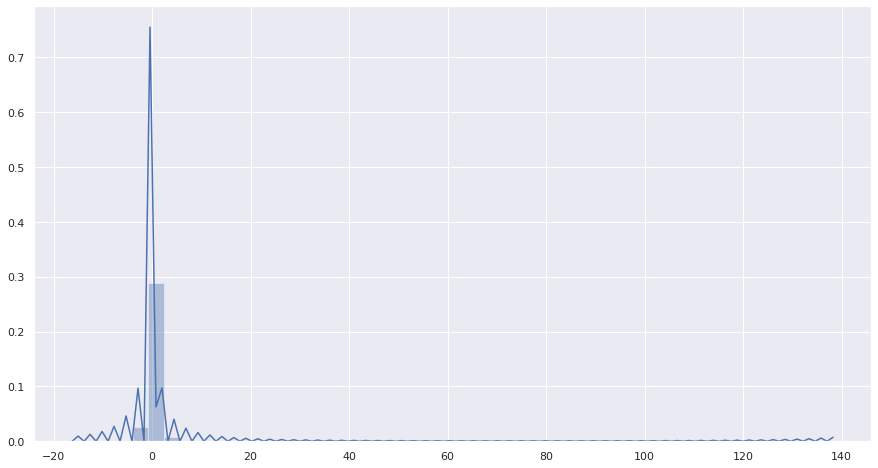

In [150]:
sns.set(rc={'figure.figsize':(15,8)})

sns.distplot(train)
    

In [152]:
#  предварительно поиграем на основе тренировочной выборки для подбора параметров
features_test, features_train, target_test, target_train = train_test_split(    
    imputed_train, target, test_size=0.2, random_state=12345)

In [153]:
model = CatBoostClassifier( 
                            class_weights=cw)
model.fit(features_train, target_train, verbose=False)
pred_test = model.predict(features_test)
print( f1_score(target_test, pred_test, average='macro'))

0.5107292052957269


In [ ]:
model = CatBoostClassifier( 
                            class_weights=cw)
model.fit(imputed_train, target, verbose=False)
pred = model.predict(imputed_test)

In [ ]:
pred = pd.DataFrame(pred)
output = pd.DataFrame({'ID': ID_col, 'Predicted': pred[0]})
output.to_csv('my_submission3.csv', index=False)
print("Your submission was successfully saved!")